# Init Bionic VTOL

In [1]:
include("../Flyonic.jl");
using .Flyonic;

using Rotations; # used for initial position

using ReinforcementLearning;
using StableRNGs;
using Flux;
using Flux.Losses;
using Random;
using IntervalSets;
using LinearAlgebra;
using Distributions;

using Plots;
using Statistics;

using BSON: @save, @load # save mode

In [2]:
create_visualization();

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8701
└ @ MeshCat /home/larissa/.julia/packages/MeshCat/Ax8pH/src/visualizer.jl:73


In [3]:
# indicates how many threads Julia was started with. This is important for the multi-threaded environment
Threads.nthreads()

1

In [4]:
eth_vtol_param["gravity"] = 0; # 9.81;

In [5]:
DESIRED_x = [-4.0, 0.0, 4.0] # desired distance    
angle = -pi/8.0 # 
DESIRED_R = Matrix(UnitQuaternion(RotY(angle)*RotX(pi/2.0)*RotZ(pi/2.0)))

create_VTOL("fixgoal", actuators = false, color_vec=[1.0; 0.0; 0.0; 1.0]);
set_transform("fixgoal", DESIRED_x ,QuatRotation(DESIRED_R)); 

# Create Reinforcement Learning Environment

In [6]:
mutable struct VtolEnv{A,T,ACT,R<:AbstractRNG} <: AbstractEnv # Parametric Constructor for a subtype of AbstractEnv
    action_space::A
    observation_space::Space{Vector{ClosedInterval{T}}}
    state::Vector{T}
    action::ACT
    done::Bool
    t::T # time
    rng::R

    name::String #for multible environoments
    visualization::Bool
    realtime::Bool
    
    # Everything you need aditionaly can also go in here.
    x_W::Vector{T}
    v_B::Vector{T}
    R_W::Matrix{T}
    ω_B::Vector{T}
    wind_W::Vector{T}
    Δt::T
    
    # Bonus / Target
    x_d_W::Vector{T}
    R_d_W::Matrix{T}
    
    covered_line::T
    previously_covered_line::T
end

In [7]:
# define a keyword-based constructor for the type declared in the mutable struct typedef. 
# It could also be done with the macro Base.@kwdef.
function VtolEnv(;
     
    #continuous = true,
    rng = Random.GLOBAL_RNG, # Random number generation
    name = "vtol",
    visualization = false,
    realtime = false,
    kwargs... # let the function take an arbitrary number of keyword arguments 
)
    
    T = Float64; # explicit type which is used e.g. in state. Cannot be altered due to the poor matrix defininon.

    #action_space = Base.OneTo(21) # 21 discrete positions for the flaps
    
    action_space = Space(
        ClosedInterval{T}[
            0.0..2.0, # propeller 1
            0.0..2.0, # propeller 2
            ], 
    )

    
    state_space = Space( # Three continuous values in state space.
        ClosedInterval{T}[
            
            # If you are not flying horizontally, you can later switch gravitation 
            # back on and counteract it with the rotors as well.
            # In addition, once the drone has flown over its target, 
            # it can "fall down" and does not have to turn around.
            
            # orientate yourself on the state space from the paper
            typemin(T)..typemax(T), # position along x
            typemin(T)..typemax(T), # position along y
            typemin(T)..typemax(T), # orientation along x: REALLY NEEDED?
            typemin(T)..typemax(T), # orientation along z
            typemin(T)..typemax(T), # velocity along x BODY coordinates
            typemin(T)..typemax(T), # velocity along y BODY coordinates
            typemin(T)..typemax(T), # rotational velocity along z BODY coordinates
            
            typemin(T)..typemax(T), # position error along x
            typemin(T)..typemax(T), # position error along y: CHANGED TO Y
            # Not used in Paper!!!
            typemin(T)..typemax(T), # target rotation along x (better than angle for neural networks)
            typemin(T)..typemax(T), # target rotation along z (better than angle for neural networks)
            typemin(T)..typemax(T), # The distance along the connecting line which has been covered
            typemin(T)..typemax(T), # The distance along the connecting line which has been previously covered
            
            ], 
    )

    # Calculate random vector & angle

    #################################
    
    if visualization
        create_VTOL(name, actuators = true, color_vec=[1.0; 1.0; 0.6; 1.0]);
    end

    environment = VtolEnv(
        action_space,
        state_space,
        zeros(T, 10), # current state, needs to be extended. 
        rand(action_space),
        false, # episode done ?
        0.0, # time
        rng, # random number generator  
        name,
        visualization,
        realtime,
        zeros(T, 3), # x_W
        zeros(T, 3), # v_B
        #Matrix(UnitQuaternion((RotX(pi)))),
        [1.0 0.0 0.0; 0.0 -1.0 0.0; 0.0 0.0 -1.0], # R_W Float64... so T needs to be Float64
        zeros(T, 3), # ω_B
        zeros(T, 3), # wind_W
        T(0.025), # Δt 
        # TODO Random
        DESIRED_x, # desired distance 
        DESIRED_R, # desired orientation
        0.0,
        0.0,
    )
    
    
    reset!(environment)
    
    return environment
    
end;

Just for explanation:

1. A mutable Struct is created. A struct is a constructor and a constructor is a function that creates new objects.
2. A outer keyword-based constructor method is added for the type declared in the mutable struct typedef before.

So now we have a function with two methods. Julia will decide which method to call by multiple dispatch.

In [8]:
methods(VtolEnv)

# 2 methods for type constructor:
[1] VtolEnv(; rng, name, visualization, realtime, kwargs...) in Main at In[7]:3
[2] VtolEnv(action_space::A, observation_space::Space{Array{ClosedInterval{T}, 1}}, state::Vector{T}, action::ACT, done::Bool, t::T, rng::R, name::String, visualization::Bool, realtime::Bool, x_W::Vector{T}, v_B::Vector{T}, R_W::Matrix{T}, ω_B::Vector{T}, wind_W::Vector{T}, Δt::T, x_d_W::Vector{T}, R_d_W::Matrix{T}, covered_line::T, previously_covered_line::T) where {A, T, ACT, R<:AbstractRNG} in Main at In[6]:2

# Define the RL interface

In [9]:
Random.seed!(env::VtolEnv, seed) = Random.seed!(env.rng, seed)
RLBase.action_space(env::VtolEnv) = env.action_space
RLBase.state_space(env::VtolEnv) = env.observation_space
RLBase.is_terminated(env::VtolEnv) = env.done
RLBase.state(env::VtolEnv) = env.state

In [10]:
function computeReward(env::VtolEnv{A,T}) where {A,T}
    
    stay_alive = 0.0 # You have a racing drone. You want to get to your destination as quickly as possible.
    
    distance_goal = exp(-sum((env.x_W - env.x_d_W).^2)/10)*100.0
    
    limit_rotation = abs(env.ω_B[3])*10.0

    progress = exp((-(env.covered_line-norm(env.x_d_W))^2)/10)*100.0
    
    new_progress = (env.covered_line-env.previously_covered_line)*100

    # TODO: Make yourself comfortable with what this is
    difference_angle = exp(-sum((env.R_W[:,1] - env.R_d_W[:,1]).^2))*10.0
    #    difference_angle = exp(-sum(((env.R_W[:,1] - env.R_d_W[:,1]).^2)))*10#*10.0 #0 was good
      
    #print("\ncovered: \n")
    #print(env.covered_line)
    #print("\nnew: \n")
    #print(env.previously_covered_line)
    #print("\n")
    #print("\n")

    env.previously_covered_line = env.covered_line

    #print("distance_goal: \n")
    #print(distance_goal)
    #print("\nlimit_rotation: \n")
    #print(limit_rotation)
    #print("\nprogress: \n")
    #print(progress)
    #print("\nnew_progress: \n")
    #print(new_progress)
    #print("\ndifference_angle: \n")
    #print(difference_angle)
    #print("\n")
    #print("\n")

    return progress + new_progress + distance_goal - limit_rotation - difference_angle
end


RLBase.reward(env::VtolEnv{A,T}) where {A,T} = computeReward(env)

In [11]:
function RLBase.reset!(env::VtolEnv{A,T}) where {A,T}
    
    # Visualize initial state
    if env.visualization
        set_transform(env.name, env.x_W, QuatRotation(env.R_W));
        set_actuators(env.name, [0.0; 0.0; 0.0; 0.0])
    end
    
    env.x_W = [0.0; 0.0; 0.0];
    env.v_B = [0.0; 0.0; 0.0];
    env.R_W = Matrix(UnitQuaternion(RotX(pi)))#Matrix(UnitQuaternion(RotZ(-pi/2.0)*RotY(-pi/2.0)*RotX(pi)));
    #env.R_W = Matrix(UnitQuaternion(RotX(pi)));
    env.ω_B = [0.0; 0.0; 0.0];
    env.wind_W = [0.0; 0.0; 0.0];

    env.x_d_W = [rand(Uniform(0,10)), rand(Uniform(-10,10)), 0.0]
    #env.angle_d_W = calculateAngle([1.0 ,0.0, 0.0], env.x_d_W) # desired angle
    #x_vec = [1.0; 0.0; 0.0]
    #env.angle_d_W = calculateAngle(x_vec, env.x_d_W) # Should the drone arrive at the target like this or is there another idea behind it?
    angle = calculateAngle([1.0 ,0.0, 0.0], env.x_d_W)
    env.R_d_W = Matrix(UnitQuaternion(RotZ(angle)*RotX(pi)))

    env.covered_line = 0.0
    env.previously_covered_line = 0.0
    
    if env.visualization
        create_VTOL("fixgoal", actuators = false, color_vec=[1.0; 0.0; 0.0; 1.0]);
        set_transform("fixgoal", env.x_d_W ,QuatRotation(env.R_d_W)); 
    end

    env.state = [env.x_W[1];
                 env.x_W[2];
                 env.R_W[1,1];
                 env.R_W[3,1];
                 env.v_B[1];
                 env.v_B[2];
                 env.ω_B[3];
                 env.x_W[1] - env.x_d_W[1];
                 env.x_W[2] - env.x_d_W[2]; # CHANGED TO Y
                 env.R_d_W[1,1];
                 env.R_d_W[3,1];
                 env.covered_line;
                 env.previously_covered_line] 
    
    env.t = 0.0
    env.action = [0.0, 0.0]
    env.done = false
    nothing

end;

In [12]:
# defines a methods for a callable object.
# So when a VtolEnv object is created, it has this method that can be called
function (env::VtolEnv)(a)

    # set the propeller trust and the two flaps 2D case
    next_action = [a[1], a[2], 0.0, 0.0]
   
    _step!(env, next_action)
end

In [13]:
env = VtolEnv();

In [14]:
methods(env) # Just to explain which methods the object has

# 3 methods for callable object:
[1] (env::VtolEnv)(a) in Main at In[12]:3
[2] (env::AbstractEnv)(action) in ReinforcementLearningBase
[3] (env::AbstractEnv)(action, player) in ReinforcementLearningBase

In [15]:
function _step!(env::VtolEnv, next_action)
    
    # caluclate wind impact
    v_in_wind_B = vtol_add_wind(env.v_B, env.R_W, env.wind_W)
    # caluclate aerodynamic forces
    torque_B, force_B = vtol_model(v_in_wind_B, next_action, eth_vtol_param);
    # Limit to 2D
    force_B[3] = 0.0; # Body Z
    env.v_B[3] = 0.0;
    torque_B[1] = 0.0; torque_B[2] = 0.0;  # Body X and Y
    env.ω_B[1] = 0.0; env.ω_B[2] = 0.0;
    # integrate rigid body dynamics for Δt
    env.x_W, env.v_B, env.R_W, env.ω_B, time = rigid_body_simple(torque_B, force_B, env.x_W, env.v_B, env.R_W, env.ω_B, env.t, env.Δt, eth_vtol_param)
    env.covered_line = dot(env.x_W, env.x_d_W)/(norm(env.x_d_W))
    
    if env.realtime
        sleep(env.Δt) # TODO: just a dirty hack. this is of course slower than real time.
    end

    # Visualize the new state 
    if env.visualization
        set_transform(env.name, env.x_W, QuatRotation(env.R_W));
        set_actuators(env.name, next_action)
    end
 
    env.t += env.Δt
    
    # State space
    #rot = Rotations.params(RotYXZ(env.R_W))[3]
    #env.state[1] = env.x_W[1] # world position in x
    #env.state[2] = env.ω_B[2] # world position in y
    #env.state[3] = rot # rotation around z
    #rot = Rotations.params(RotYXZ(env.R_W))[1]
    
    
    env.state[1] = env.x_W[1]; # position along x
    env.state[2] = env.x_W[2];  # position along y
    env.state[3] = env.R_W[1,1];    # orientation along x
    env.state[4] = env.R_W[3,1];   # orientation along z
    env.state[5] = env.v_B[1];  # velocity along x BODY coordinates
    env.state[6] = env.v_B[2];  # velocity along y BODY coordinates
    env.state[7] = env.ω_B[3];  # rotational velocity along z BODY coordinates
    env.state[8] = env.x_W[1] - env.x_d_W[1];   # position error along x
    env.state[9] = env.x_W[2] - env.x_d_W[2];   # position error along y
    env.state[10] = env.R_d_W[1,1];  # target rotation along x (better than angle for neural networks)
    env.state[11] = env.covered_line    # Covered distance along line after step
    env.state[12] = env.previously_covered_line # Covered distance along line before step
    #env.R_d_W[3,1];    # target orientation along z
    
    #print("\nSTEP: \n")
    # Termination criteria
    # TODO: Use many termination criteria so that you do not train unnecessarily in wrong areas
    env.done = 

        # TODO Zu lang
        # TODO Zu weit weg
        # TODO Ziel erreicht

        # After time... How fast is drone+Range of desired point
        # After reaching position (circle of r_tol)
        norm(env.ω_B) > 50.0 || 
        norm(env.v_B) > 50.0 || # stop if body is too fast
        #env.x_W[3] < -10.0 || # stop if body is below -10m
        #0.0 > rot || # Stop if the drone is pitched 90°.
        #rot > pi || # Stop if the drone is pitched 90°.
        sum((env.x_W - env.x_d_W).^2) < 1.0 ||
        #sum((env.x_W - env.x_d_W).^2) > 5000.0||
        env.t > 5.0 # stop after 10s
    nothing
end;

In [16]:
RLBase.test_runnable!(env)

Test Summary:              | Pass  Total  Time
random policy with VtolEnv | 2000   2000  3.1s


Test.DefaultTestSet("random policy with VtolEnv", Any[], 2000, false, false, true, 1.6689580306288e9, 1.668958033736598e9)

Show an overview of the environment.

# Setup of a reinforcement learning experiment.

In [17]:
seed = 123    
rng = StableRNG(seed)
    N_ENV = 8
    UPDATE_FREQ = 1024
    
    
    # define multiple environments for parallel training
    env = MultiThreadEnv([
        # use different names for the visualization
        VtolEnv(; rng = StableRNG(hash(seed+i)), name = "vtol$i") for i in 1:N_ENV
    ])

MultiThreadEnv(8 x VtolEnv)

In [18]:
# Define the function approximator
    ns, na = length(state(env[1])), length(action_space(env[1]))
    approximator = ActorCritic(
                actor = GaussianNetwork(
                    pre = Chain(
                    Dense(ns, 16, relu; initW = glorot_uniform(rng)),#
                    Dense(16, 16, relu; initW = glorot_uniform(rng)),
                    ),
                    μ = Chain(Dense(16, na; initW = glorot_uniform(rng))),
                    logσ = Chain(Dense(16, na; initW = glorot_uniform(rng))),
                ),
                critic = Chain(
                    Dense(ns, 16, relu; initW = glorot_uniform(rng)),
                    Dense(16, 16, relu; initW = glorot_uniform(rng)),
                    Dense(16, 1; initW = glorot_uniform(rng)),
                ),
                optimizer = ADAM(1e-3),
            );

In [19]:
    agent = Agent( # A wrapper of an AbstractPolicy
        # AbstractPolicy: the policy to use
        policy = PPOPolicy(;
                    approximator = approximator |> gpu,
                    update_freq=UPDATE_FREQ,
                    dist = Normal,
                    # For parameters visit the docu: https://juliareinforcementlearning.org/docs/rlzoo/#ReinforcementLearningZoo.PPOPolicy
                    ),
        
        # AbstractTrajectory: used to store transitions between an agent and an environment source
        trajectory = PPOTrajectory(;
            capacity = UPDATE_FREQ,
            state = Matrix{Float64} => (ns, N_ENV),
            action = Matrix{Float64} => (na, N_ENV),
            action_log_prob = Vector{Float64} => (N_ENV,),
            reward = Vector{Float64} => (N_ENV,),
            terminal = Vector{Bool} => (N_ENV,),
        ),
    );


┌ Info: The GPU function is being called but the GPU is not accessible. 
│ Defaulting back to the CPU. (No action is required if you want to run on the CPU).
└ @ Flux /home/larissa/.julia/packages/Flux/7nTyc/src/functor.jl:187


In [20]:
function saveModel(t, agent, env)
    model = cpu(agent.policy.approximator)   
    f = joinpath("./RL_models/", "vtol_2D_ppo_$t.bson")
    @save f model
    println("parameters at step $t saved to $f")
end;

In [21]:
function loadModel()
    f = joinpath("./RL_models/", "vtol_2D_ppo_3100000.bson")
    @load f model
    return model
end;

In [22]:
function validate_policy(t, agent, env)
    run(agent.policy, test_env, StopAfterEpisode(1), episode_test_reward_hook)
    # the result of the hook
    println("test reward at step $t: $(mean(episode_test_reward_hook.rewards))")
    
end;

episode_test_reward_hook = TotalRewardPerEpisode(;is_display_on_exit=false)
# create a env only for reward test
test_env = VtolEnv(;name = "testVTOL", visualization = true, realtime = true);

In [23]:
#agent.policy.approximator = loadModel();

In [24]:
ReinforcementLearning.run(
    agent,
    env,
    StopAfterStep(4_000_000),
    ComposedHook(
        DoEveryNStep(saveModel, n=100_000), 
        DoEveryNStep(validate_policy, n=10_000)),
)


Progress:   0%|▏                                        |  ETA: 9:18:02m:05

test reward at step 10000: -12584.921437776768


Progress:   0%|▎                                        |  ETA: 5:35:03

test reward at step 20000: -10693.72546053047


Progress:   1%|▎                                        |  ETA: 3:45:02

test reward at step 30000: -7798.624565501198


Progress:   1%|▍                                        |  ETA: 3:07:17

test reward at step 40000: -9119.218941564683


Progress:   1%|▌                                        |  ETA: 2:33:11

test reward at step 50000: -9777.455929679714


Progress:   1%|▋                                        |  ETA: 2:17:33

test reward at step 60000: -10231.002680327327


Progress:   2%|▊                                        |  ETA: 2:05:32

test reward at step 70000: -10037.288565646491


Progress:   2%|▊                                        |  ETA: 1:54:03

test reward at step 80000: -10929.917939571907


Progress:   2%|▉                                        |  ETA: 1:44:34

test reward at step 90000: -10314.13321197564


Progress:   2%|█                                        |  ETA: 1:38:56

parameters at step 100000 saved to ./RL_models/vtol_2D_ppo_100000.bson
test reward at step 100000: -10121.591134495637


Progress:   3%|█▏                                       |  ETA: 1:37:27

test reward at step 110000: -9370.507217744016


Progress:   3%|█▎                                       |  ETA: 1:33:32

test reward at step 120000: -9171.993759153645


Progress:   3%|█▍                                       |  ETA: 1:29:59

test reward at step 130000: -8919.533683236139


Progress:   3%|█▍                                       |  ETA: 1:25:19

test reward at step 140000: -9242.050392575316


Progress:   4%|█▌                                       |  ETA: 1:23:27

test reward at step 150000: -8967.796651454679


Progress:   4%|█▋                                       |  ETA: 1:21:39

test reward at step 160000: -9221.893331400905


Progress:   4%|█▊                                       |  ETA: 1:18:45

test reward at step 170000: -9077.905767152408


Progress:   4%|█▉                                       |  ETA: 1:15:42

test reward at step 180000: -8912.37866335991


Progress:   5%|██                                       |  ETA: 1:14:25

test reward at step 190000: -8844.206417004234


Progress:   5%|██                                       |  ETA: 1:12:07

parameters at step 200000 saved to ./RL_models/vtol_2D_ppo_200000.bson
test reward at step 200000: -8760.374824945971


Progress:   5%|██▏                                      |  ETA: 1:10:22

test reward at step 210000: -8706.328984666321


Progress:   5%|██▎                                      |  ETA: 1:08:17

test reward at step 220000: -8242.957984302811


Progress:   6%|██▍                                      |  ETA: 1:06:48

test reward at step 230000: -8285.36079713005


Progress:   6%|██▌                                      |  ETA: 1:06:15

test reward at step 240000: -8443.8251670021


Progress:   6%|██▌                                      |  ETA: 1:05:16

test reward at step 250000: -8786.070856226677


Progress:   6%|██▋                                      |  ETA: 1:04:29

test reward at step 260000: -8727.099359550386


Progress:   7%|██▊                                      |  ETA: 1:03:18

test reward at step 270000: -8699.815541151122


Progress:   7%|██▉                                      |  ETA: 1:02:27

test reward at step 280000: -8492.953825054186


Progress:   7%|███                                      |  ETA: 1:01:09

test reward at step 290000: -8460.169819181017


Progress:   7%|███▏                                     |  ETA: 1:00:12

parameters at step 300000 saved to ./RL_models/vtol_2D_ppo_300000.bson
test reward at step 300000: -8495.71783357255


Progress:   8%|███▏                                     |  ETA: 0:59:16

test reward at step 310000: -8442.496197659706


Progress:   8%|███▎                                     |  ETA: 0:59:27

test reward at step 320000: -8716.485824474757


Progress:   8%|███▍                                     |  ETA: 0:58:28

test reward at step 330000: -8346.402566162285


Progress:   9%|███▌                                     |  ETA: 0:57:59

test reward at step 340000: -8452.128429085931


Progress:   9%|███▋                                     |  ETA: 0:57:10

test reward at step 350000: -8466.140404616404


Progress:   9%|███▋                                     |  ETA: 0:56:56

test reward at step 360000: -8465.648405038635


Progress:   9%|███▊                                     |  ETA: 0:56:08

test reward at step 370000: -8471.773512051866


Progress:   9%|███▉                                     |  ETA: 0:55:35

test reward at step 380000: -8428.166928779787


Progress:  10%|████                                     |  ETA: 0:55:02

test reward at step 390000: -8476.703306885714


Progress:  10%|████▏                                    |  ETA: 0:54:34

parameters at step 400000 saved to ./RL_models/vtol_2D_ppo_400000.bson
test reward at step 400000: -8532.11483894125


Progress:  10%|████▎                                    |  ETA: 0:54:06

test reward at step 410000: -8419.517794478254


Progress:  10%|████▎                                    |  ETA: 0:53:38

test reward at step 420000: -8329.293810374547


Progress:  11%|████▍                                    |  ETA: 0:53:11

test reward at step 430000: -8330.767317386679


Progress:  11%|████▌                                    |  ETA: 0:53:02

test reward at step 440000: -8494.20625913397


Progress:  11%|████▋                                    |  ETA: 0:52:20

test reward at step 450000: -8244.788288881824


Progress:  11%|████▊                                    |  ETA: 0:52:09

test reward at step 460000: -8587.923200522093


Progress:  12%|████▉                                    |  ETA: 0:51:47

test reward at step 470000: -8842.479128324525


Progress:  12%|████▉                                    |  ETA: 0:51:35

test reward at step 480000: -8909.62594614698


Progress:  12%|█████                                    |  ETA: 0:50:59

test reward at step 490000: -9004.875853854264


Progress:  12%|█████▏                                   |  ETA: 0:50:46

parameters at step 500000 saved to ./RL_models/vtol_2D_ppo_500000.bson
test reward at step 500000: -8948.426780671245


Progress:  13%|█████▎                                   |  ETA: 0:50:47

test reward at step 510000: -9388.255186598788


Progress:  13%|█████▎                                   |  ETA: 0:50:32

test reward at step 520000: -9528.212607721538


Progress:  13%|█████▍                                   |  ETA: 0:50:02

test reward at step 530000: -9485.890349293153


Progress:  13%|█████▌                                   |  ETA: 0:49:43

test reward at step 540000: -9607.06297072732


Progress:  14%|█████▋                                   |  ETA: 0:49:45

test reward at step 550000: -9766.331238004297


Progress:  14%|█████▊                                   |  ETA: 0:49:23

test reward at step 560000: -10035.426270472653


Progress:  14%|█████▉                                   |  ETA: 0:49:24

test reward at step 570000: -10297.691350784584


Progress:  14%|█████▉                                   |  ETA: 0:49:21

test reward at step 580000: -10552.775054776892


Progress:  15%|██████                                   |  ETA: 0:49:15

test reward at step 590000: -10501.88415070551


Progress:  15%|██████▏                                  |  ETA: 0:49:07

parameters at step 600000 saved to ./RL_models/vtol_2D_ppo_600000.bson
test reward at step 600000: -10307.23294652283


Progress:  15%|██████▎                                  |  ETA: 0:48:42

test reward at step 610000: -10403.876338069265


Progress:  15%|██████▍                                  |  ETA: 0:48:39

test reward at step 620000: -10551.261734774052


Progress:  16%|██████▌                                  |  ETA: 0:48:22

test reward at step 630000: -10934.293567801507


Progress:  16%|██████▌                                  |  ETA: 0:48:21

test reward at step 640000: -11056.379672750452


Progress:  16%|██████▋                                  |  ETA: 0:48:19

test reward at step 650000: -11083.00384107518


Progress:  16%|██████▊                                  |  ETA: 0:47:58

test reward at step 660000: -11484.063769453598


Progress:  17%|██████▉                                  |  ETA: 0:47:48

test reward at step 670000: -11622.734858294774


Progress:  17%|███████                                  |  ETA: 0:47:41

test reward at step 680000: -11685.932574515951


Progress:  17%|███████▏                                 |  ETA: 0:47:44

test reward at step 690000: -11735.72484511839


Progress:  17%|███████▏                                 |  ETA: 0:47:20

parameters at step 700000 saved to ./RL_models/vtol_2D_ppo_700000.bson
test reward at step 700000: -11725.422119254607


Progress:  18%|███████▎                                 |  ETA: 0:47:02

test reward at step 710000: -11682.909745025558


Progress:  18%|███████▍                                 |  ETA: 0:46:43

test reward at step 720000: -11698.14352891788


Progress:  18%|███████▌                                 |  ETA: 0:46:32

test reward at step 730000: -11678.724951738977


Progress:  18%|███████▋                                 |  ETA: 0:46:16

test reward at step 740000: -11596.986666834693


Progress:  19%|███████▋                                 |  ETA: 0:46:00

test reward at step 750000: -11443.911571953


Progress:  19%|███████▊                                 |  ETA: 0:45:58

test reward at step 760000: -11433.739885260025


Progress:  19%|███████▉                                 |  ETA: 0:45:41

test reward at step 770000: -11430.035359402267


Progress:  19%|████████                                 |  ETA: 0:45:36

test reward at step 780000: -11456.821910066235


Progress:  20%|████████▏                                |  ETA: 0:45:39

test reward at step 790000: -11411.564110836678


Progress:  20%|████████▏                                |  ETA: 0:45:32

parameters at step 800000 saved to ./RL_models/vtol_2D_ppo_800000.bson
test reward at step 800000: -11481.3542304966


Progress:  20%|████████▎                                |  ETA: 0:45:39

test reward at step 810000: -11328.686248425933


Progress:  20%|████████▍                                |  ETA: 0:45:15

test reward at step 820000: -11422.664753034473


Progress:  21%|████████▌                                |  ETA: 0:45:03

test reward at step 830000: -11391.719637716838


Progress:  21%|████████▋                                |  ETA: 0:44:51

test reward at step 840000: -11754.574504778438


Progress:  21%|████████▊                                |  ETA: 0:44:49

test reward at step 850000: -12219.516800854646


Progress:  21%|████████▊                                |  ETA: 0:44:46

test reward at step 860000: -12261.485907974742


Progress:  22%|████████▉                                |  ETA: 0:44:41

test reward at step 870000: -12274.797939300412


Progress:  22%|█████████                                |  ETA: 0:44:32

test reward at step 880000: -12397.997374040726


Progress:  22%|█████████▏                               |  ETA: 0:44:27

test reward at step 890000: -12359.859899712064


Progress:  22%|█████████▎                               |  ETA: 0:44:28

parameters at step 900000 saved to ./RL_models/vtol_2D_ppo_900000.bson
test reward at step 900000: -12422.395994468647


Progress:  23%|█████████▍                               |  ETA: 0:44:15

test reward at step 910000: -12353.113741072837


Progress:  23%|█████████▍                               |  ETA: 0:44:13

test reward at step 920000: -12298.930648412084


Progress:  23%|█████████▌                               |  ETA: 0:44:09

test reward at step 930000: -12137.59808562519


Progress:  23%|█████████▋                               |  ETA: 0:43:50

test reward at step 940000: -12065.667363159824


Progress:  24%|█████████▊                               |  ETA: 0:43:46

test reward at step 950000: -12175.350660181866


Progress:  24%|█████████▉                               |  ETA: 0:43:54

test reward at step 960000: -12057.849979619648


Progress:  24%|██████████                               |  ETA: 0:43:44

test reward at step 970000: -12089.547432105546


Progress:  24%|██████████                               |  ETA: 0:43:23

test reward at step 980000: -12094.55179860012


Progress:  25%|██████████▏                              |  ETA: 0:43:06

test reward at step 990000: -11961.107007198812


Progress:  25%|██████████▎                              |  ETA: 0:43:02

parameters at step 1000000 saved to ./RL_models/vtol_2D_ppo_1000000.bson
test reward at step 1000000: -12089.861564077626


Progress:  25%|██████████▍                              |  ETA: 0:43:04

test reward at step 1010000: -12026.128643965523


Progress:  25%|██████████▌                              |  ETA: 0:42:56

test reward at step 1020000: -12054.663026475213


Progress:  26%|██████████▌                              |  ETA: 0:42:50

test reward at step 1030000: -12211.539327027354


Progress:  26%|██████████▋                              |  ETA: 0:42:45

test reward at step 1040000: -12488.484775877474


Progress:  26%|██████████▊                              |  ETA: 0:42:44

test reward at step 1050000: -12376.011228761288


Progress:  27%|██████████▉                              |  ETA: 0:42:49

test reward at step 1060000: -12229.995864936609


Progress:  27%|███████████                              |  ETA: 0:42:40

test reward at step 1070000: -12322.465920227069


Progress:  27%|███████████                              |  ETA: 0:42:22

test reward at step 1080000: -12254.007299015551


Progress:  27%|███████████▏                             |  ETA: 0:42:18

test reward at step 1090000: -12368.345958163573


Progress:  27%|███████████▎                             |  ETA: 0:42:10

parameters at step 1100000 saved to ./RL_models/vtol_2D_ppo_1100000.bson
test reward at step 1100000: -12254.526306423595


Progress:  28%|███████████▍                             |  ETA: 0:41:56

test reward at step 1110000: -12137.41548876103


Progress:  28%|███████████▌                             |  ETA: 0:41:55

test reward at step 1120000: -12065.754485784719


Progress:  28%|███████████▋                             |  ETA: 0:41:50

test reward at step 1130000: -12101.735377863051


Progress:  28%|███████████▋                             |  ETA: 0:41:44

test reward at step 1140000: -12015.104332382958


Progress:  29%|███████████▊                             |  ETA: 0:41:35

test reward at step 1150000: -11903.250062237978


Progress:  29%|███████████▉                             |  ETA: 0:41:18

test reward at step 1160000: -12046.594836249013


Progress:  29%|████████████                             |  ETA: 0:41:12

test reward at step 1170000: -12090.516415600794


Progress:  29%|████████████▏                            |  ETA: 0:40:56

test reward at step 1180000: -11981.27914107127


Progress:  30%|████████████▏                            |  ETA: 0:40:44

test reward at step 1190000: -11940.866191765377


Progress:  30%|████████████▎                            |  ETA: 0:40:40

parameters at step 1200000 saved to ./RL_models/vtol_2D_ppo_1200000.bson


Progress:  30%|████████████▎                            |  ETA: 0:40:40

test reward at step 1200000: -11978.302469830944


Progress:  30%|████████████▍                            |  ETA: 0:40:22

test reward at step 1210000: -11974.616356473225


Progress:  30%|████████████▌                            |  ETA: 0:40:08

test reward at step 1220000: -11967.899049534353


Progress:  31%|████████████▋                            |  ETA: 0:39:53

test reward at step 1230000: -11918.018364259002


Progress:  31%|████████████▊                            |  ETA: 0:39:48

test reward at step 1240000: -11815.783867955646


Progress:  31%|████████████▊                            |  ETA: 0:39:36

test reward at step 1250000: -11885.003165133376


Progress:  32%|████████████▉                            |  ETA: 0:39:36

test reward at step 1260000: -11866.124858857918


Progress:  32%|█████████████                            |  ETA: 0:39:21

test reward at step 1270000: -11911.02892776894


Progress:  32%|█████████████▏                           |  ETA: 0:39:13

test reward at step 1280000: -11813.624770418588


Progress:  32%|█████████████▎                           |  ETA: 0:38:54

test reward at step 1290000: -11731.367934952967


Progress:  32%|█████████████▍                           |  ETA: 0:38:43

parameters at step 1300000 saved to ./RL_models/vtol_2D_ppo_1300000.bson
test reward at step 1300000: -11671.75480875913


Progress:  33%|█████████████▍                           |  ETA: 0:38:40

test reward at step 1310000: -11657.798844557787


Progress:  33%|█████████████▌                           |  ETA: 0:38:27

test reward at step 1320000: -11671.207191713542


Progress:  33%|█████████████▋                           |  ETA: 0:38:15

test reward at step 1330000: -11562.774341880637


Progress:  33%|█████████████▊                           |  ETA: 0:38:00

test reward at step 1340000: -11584.41355699642


Progress:  34%|█████████████▉                           |  ETA: 0:37:45

test reward at step 1350000: -11540.271208342114


Progress:  34%|█████████████▉                           |  ETA: 0:37:40

test reward at step 1360000: -11481.105080295063


Progress:  34%|██████████████                           |  ETA: 0:37:35

test reward at step 1370000: -11501.200422407637


Progress:  34%|██████████████▏                          |  ETA: 0:37:24

test reward at step 1380000: -11461.124246911088


Progress:  35%|██████████████▎                          |  ETA: 0:37:18

test reward at step 1390000: -11362.38742645965


Progress:  35%|██████████████▍                          |  ETA: 0:37:01

parameters at step 1400000 saved to ./RL_models/vtol_2D_ppo_1400000.bson
test reward at step 1400000: -11259.143408002523


Progress:  35%|██████████████▌                          |  ETA: 0:36:56

test reward at step 1410000: -11163.980603394079


Progress:  35%|██████████████▌                          |  ETA: 0:36:49

test reward at step 1420000: -11205.75710017545


Progress:  36%|██████████████▋                          |  ETA: 0:36:39

test reward at step 1430000: -11170.678232436741


Progress:  36%|██████████████▊                          |  ETA: 0:36:34

test reward at step 1440000: -11208.93689907306


Progress:  36%|██████████████▉                          |  ETA: 0:36:25

test reward at step 1450000: -11250.607780605871


Progress:  36%|███████████████                          |  ETA: 0:36:14

test reward at step 1460000: -11295.791111384147


Progress:  37%|███████████████                          |  ETA: 0:36:05

test reward at step 1470000: -11319.42565641311


Progress:  37%|███████████████▏                         |  ETA: 0:35:52

test reward at step 1480000: -11251.410633580264


Progress:  37%|███████████████▎                         |  ETA: 0:35:46

test reward at step 1490000: -11268.57065387694


Progress:  37%|███████████████▍                         |  ETA: 0:35:39

parameters at step 1500000 saved to ./RL_models/vtol_2D_ppo_1500000.bson
test reward at step 1500000: -11260.020517093924


Progress:  38%|███████████████▌                         |  ETA: 0:35:26

test reward at step 1510000: -11228.56256498497


Progress:  38%|███████████████▋                         |  ETA: 0:35:20

test reward at step 1520000: -11182.279684903051


Progress:  38%|███████████████▋                         |  ETA: 0:35:09

test reward at step 1530000: -11148.057720085948


Progress:  38%|███████████████▊                         |  ETA: 0:35:00

test reward at step 1540000: -11063.90818024557


Progress:  39%|███████████████▉                         |  ETA: 0:34:45

test reward at step 1550000: -11028.93581840187


Progress:  39%|████████████████                         |  ETA: 0:34:39

test reward at step 1560000: -10949.2397764128


Progress:  39%|████████████████▏                        |  ETA: 0:34:27

test reward at step 1570000: -10839.967068621583


Progress:  39%|████████████████▎                        |  ETA: 0:34:20

test reward at step 1580000: -10759.968227646075


Progress:  40%|████████████████▎                        |  ETA: 0:34:07

test reward at step 1590000: -10803.830731386834


Progress:  40%|████████████████▍                        |  ETA: 0:33:57

parameters at step 1600000 saved to ./RL_models/vtol_2D_ppo_1600000.bson
test reward at step 1600000: -10779.217924645589


Progress:  40%|████████████████▌                        |  ETA: 0:33:49

test reward at step 1610000: -10698.094711164249


Progress:  40%|████████████████▋                        |  ETA: 0:33:45

test reward at step 1620000: -10626.434789892119


Progress:  41%|████████████████▊                        |  ETA: 0:33:38

test reward at step 1630000: -10564.492199516864


Progress:  41%|████████████████▊                        |  ETA: 0:33:31

test reward at step 1640000: -10493.616746052807


Progress:  41%|████████████████▉                        |  ETA: 0:33:24

test reward at step 1650000: -10409.653307940178


Progress:  41%|█████████████████                        |  ETA: 0:33:13

test reward at step 1660000: -10362.520977012895


Progress:  42%|█████████████████▏                       |  ETA: 0:33:02

test reward at step 1670000: -10329.901961681853


Progress:  42%|█████████████████▎                       |  ETA: 0:32:54

test reward at step 1680000: -10328.522654646456


Progress:  42%|█████████████████▍                       |  ETA: 0:32:43

test reward at step 1690000: -10292.57444307963


Progress:  42%|█████████████████▍                       |  ETA: 0:32:34

parameters at step 1700000 saved to ./RL_models/vtol_2D_ppo_1700000.bson
test reward at step 1700000: -10265.070114727901


Progress:  43%|█████████████████▌                       |  ETA: 0:32:26

test reward at step 1710000: -10204.613276972119


Progress:  43%|█████████████████▋                       |  ETA: 0:32:19

test reward at step 1720000: -10123.64713973288


Progress:  43%|█████████████████▊                       |  ETA: 0:32:13

test reward at step 1730000: -10056.626427574856


Progress:  43%|█████████████████▉                       |  ETA: 0:32:02

test reward at step 1740000: -10075.942854075585


Progress:  44%|█████████████████▉                       |  ETA: 0:31:53

test reward at step 1750000: -10035.442098366204


Progress:  44%|██████████████████                       |  ETA: 0:31:44

test reward at step 1760000: -10047.911212670799


Progress:  44%|██████████████████▏                      |  ETA: 0:31:37

test reward at step 1770000: -10030.920594522946


Progress:  44%|██████████████████▎                      |  ETA: 0:31:30

test reward at step 1780000: -9995.909674097356


Progress:  45%|██████████████████▍                      |  ETA: 0:31:23

test reward at step 1790000: -9932.63238479824


Progress:  45%|██████████████████▌                      |  ETA: 0:31:11

parameters at step 1800000 saved to ./RL_models/vtol_2D_ppo_1800000.bson
test reward at step 1800000: -9947.023189947162


Progress:  45%|██████████████████▌                      |  ETA: 0:31:02

test reward at step 1810000: -9888.407381624294


Progress:  45%|██████████████████▋                      |  ETA: 0:30:49

test reward at step 1820000: -9871.652822952923


Progress:  46%|██████████████████▊                      |  ETA: 0:30:41

test reward at step 1830000: -9840.58642976943


Progress:  46%|██████████████████▉                      |  ETA: 0:30:33

test reward at step 1840000: -9780.570247338812


Progress:  46%|███████████████████                      |  ETA: 0:30:22

test reward at step 1850000: -9757.170458579496


Progress:  46%|███████████████████                      |  ETA: 0:30:16

test reward at step 1860000: -9697.66127416803


Progress:  47%|███████████████████▏                     |  ETA: 0:30:07

test reward at step 1870000: -9606.431015416129


Progress:  47%|███████████████████▎                     |  ETA: 0:29:55

test reward at step 1880000: -9546.604294183526


Progress:  47%|███████████████████▍                     |  ETA: 0:29:45

test reward at step 1890000: -9465.220579357154


Progress:  47%|███████████████████▌                     |  ETA: 0:29:38

parameters at step 1900000 saved to ./RL_models/vtol_2D_ppo_1900000.bson
test reward at step 1900000: -9473.595538876558


Progress:  48%|███████████████████▋                     |  ETA: 0:29:28

test reward at step 1910000: -9413.24901909851


Progress:  48%|███████████████████▋                     |  ETA: 0:29:22

test reward at step 1920000: -9353.2299035956


Progress:  48%|███████████████████▊                     |  ETA: 0:29:10

test reward at step 1930000: -9298.56320916247


Progress:  48%|███████████████████▉                     |  ETA: 0:29:00

test reward at step 1940000: -9297.76575132623


Progress:  49%|████████████████████                     |  ETA: 0:28:52

test reward at step 1950000: -9237.996468497664


Progress:  49%|████████████████████▏                    |  ETA: 0:28:41

test reward at step 1960000: -9184.287904868801


Progress:  49%|████████████████████▎                    |  ETA: 0:28:34

test reward at step 1970000: -9138.982980111417


Progress:  49%|████████████████████▎                    |  ETA: 0:28:21

test reward at step 1980000: -9203.06517961449


Progress:  50%|████████████████████▍                    |  ETA: 0:28:15

test reward at step 1990000: -9151.040791945323


Progress:  50%|████████████████████▌                    |  ETA: 0:28:05

parameters at step 2000000 saved to ./RL_models/vtol_2D_ppo_2000000.bson
test reward at step 2000000: -9148.940842134685


Progress:  50%|████████████████████▋                    |  ETA: 0:27:58

test reward at step 2010000: -9088.496231294328


Progress:  50%|████████████████████▊                    |  ETA: 0:27:51

test reward at step 2020000: -9038.450237194333


Progress:  51%|████████████████████▊                    |  ETA: 0:27:43

test reward at step 2030000: -9024.110281655367


Progress:  51%|████████████████████▉                    |  ETA: 0:27:31

test reward at step 2040000: -9004.793332719635


Progress:  51%|█████████████████████                    |  ETA: 0:27:23

test reward at step 2050000: -8966.46073580348


Progress:  51%|█████████████████████▏                   |  ETA: 0:27:16

test reward at step 2060000: -8918.490692709442


Progress:  52%|█████████████████████▎                   |  ETA: 0:27:05

test reward at step 2070000: -8834.7944571718


Progress:  52%|█████████████████████▎                   |  ETA: 0:26:57

test reward at step 2080000: -8825.78090366562


Progress:  52%|█████████████████████▍                   |  ETA: 0:26:49

test reward at step 2090000: -8764.016094765997


Progress:  52%|█████████████████████▌                   |  ETA: 0:26:43

parameters at step 2100000 saved to ./RL_models/vtol_2D_ppo_2100000.bson
test reward at step 2100000: -8729.747386194931


Progress:  53%|█████████████████████▋                   |  ETA: 0:26:33

test reward at step 2110000: -8676.954352375546


Progress:  53%|█████████████████████▊                   |  ETA: 0:26:22

test reward at step 2120000: -8655.12890590145


Progress:  53%|█████████████████████▉                   |  ETA: 0:26:14

test reward at step 2130000: -8608.83172711368


Progress:  53%|█████████████████████▉                   |  ETA: 0:26:03

test reward at step 2140000: -8607.288815160635


Progress:  54%|██████████████████████                   |  ETA: 0:25:56

test reward at step 2150000: -8537.885759749477


Progress:  54%|██████████████████████▏                  |  ETA: 0:25:49

test reward at step 2160000: -8491.561899104556


Progress:  54%|██████████████████████▎                  |  ETA: 0:25:42

test reward at step 2170000: -8427.483872255103


Progress:  55%|██████████████████████▍                  |  ETA: 0:25:37

test reward at step 2180000: -8337.828188217609


Progress:  55%|██████████████████████▌                  |  ETA: 0:25:26

test reward at step 2190000: -8275.640834859574


Progress:  55%|██████████████████████▌                  |  ETA: 0:25:19

parameters at step 2200000 saved to ./RL_models/vtol_2D_ppo_2200000.bson
test reward at step 2200000: -8225.324760280606


Progress:  55%|██████████████████████▋                  |  ETA: 0:25:09

test reward at step 2210000: -8181.550046275943


Progress:  55%|██████████████████████▊                  |  ETA: 0:24:57

test reward at step 2220000: -8123.96665594159


Progress:  56%|██████████████████████▉                  |  ETA: 0:24:50

test reward at step 2230000: -8081.479379460103


Progress:  56%|███████████████████████                  |  ETA: 0:24:41

test reward at step 2240000: -8040.029759051102


Progress:  56%|███████████████████████                  |  ETA: 0:24:32

test reward at step 2250000: -7998.526408664631


Progress:  56%|███████████████████████▏                 |  ETA: 0:24:24

test reward at step 2260000: -7985.397714886804


Progress:  57%|███████████████████████▎                 |  ETA: 0:24:19

test reward at step 2270000: -7924.929865417127


Progress:  57%|███████████████████████▍                 |  ETA: 0:24:09

test reward at step 2280000: -7872.9500015398835


Progress:  57%|███████████████████████▌                 |  ETA: 0:24:02

test reward at step 2290000: -7807.591317012793


Progress:  57%|███████████████████████▌                 |  ETA: 0:23:55

parameters at step 2300000 saved to ./RL_models/vtol_2D_ppo_2300000.bson
test reward at step 2300000: -7740.257121382887


Progress:  58%|███████████████████████▋                 |  ETA: 0:23:47

test reward at step 2310000: -7698.290577262493


Progress:  58%|███████████████████████▊                 |  ETA: 0:23:37

test reward at step 2320000: -7656.871229754954


Progress:  58%|███████████████████████▉                 |  ETA: 0:23:26

test reward at step 2330000: -7616.47328987723


Progress:  58%|████████████████████████                 |  ETA: 0:23:15

test reward at step 2340000: -7546.935137183143


Progress:  59%|████████████████████████▏                |  ETA: 0:23:08

test reward at step 2350000: -7492.815927160622


Progress:  59%|████████████████████████▏                |  ETA: 0:23:00

test reward at step 2360000: -7430.658085866263


Progress:  59%|████████████████████████▎                |  ETA: 0:22:55

test reward at step 2370000: -7406.200797739275


Progress:  59%|████████████████████████▍                |  ETA: 0:22:44

test reward at step 2380000: -7383.065843891574


Progress:  60%|████████████████████████▌                |  ETA: 0:22:37

test reward at step 2390000: -7397.980395197713


Progress:  60%|████████████████████████▋                |  ETA: 0:22:30

parameters at step 2400000 saved to ./RL_models/vtol_2D_ppo_2400000.bson
test reward at step 2400000: -7348.391543201625


Progress:  60%|████████████████████████▊                |  ETA: 0:22:21

test reward at step 2410000: -7313.46266641446


Progress:  60%|████████████████████████▊                |  ETA: 0:22:11

test reward at step 2420000: -7305.731380473323


Progress:  61%|████████████████████████▉                |  ETA: 0:22:03

test reward at step 2430000: -7291.072828403149


Progress:  61%|█████████████████████████                |  ETA: 0:21:57

test reward at step 2440000: -7277.50148959394


Progress:  61%|█████████████████████████▏               |  ETA: 0:21:49

test reward at step 2450000: -7274.608588084922


Progress:  61%|█████████████████████████▎               |  ETA: 0:21:39

test reward at step 2460000: -7253.973923596458


Progress:  62%|█████████████████████████▍               |  ETA: 0:21:30

test reward at step 2470000: -7206.895930544422


Progress:  62%|█████████████████████████▍               |  ETA: 0:21:22

test reward at step 2480000: -7202.2383949377945


Progress:  62%|█████████████████████████▌               |  ETA: 0:21:14

test reward at step 2490000: -7186.699907361045


Progress:  62%|█████████████████████████▋               |  ETA: 0:21:06

parameters at step 2500000 saved to ./RL_models/vtol_2D_ppo_2500000.bson
test reward at step 2500000: -7151.133201485363


Progress:  63%|█████████████████████████▊               |  ETA: 0:20:58

test reward at step 2510000: -7104.075449601307


Progress:  63%|█████████████████████████▉               |  ETA: 0:20:49

test reward at step 2520000: -7082.125498457362


Progress:  63%|█████████████████████████▉               |  ETA: 0:20:40

test reward at step 2530000: -7050.107788463634


Progress:  63%|██████████████████████████               |  ETA: 0:20:32

test reward at step 2540000: -7018.149466340263


Progress:  64%|██████████████████████████▏              |  ETA: 0:20:24

test reward at step 2550000: -6954.3296904551225


Progress:  64%|██████████████████████████▎              |  ETA: 0:20:17

test reward at step 2560000: -6926.105383075113


Progress:  64%|██████████████████████████▍              |  ETA: 0:20:08

test reward at step 2570000: -6918.283763264509


Progress:  64%|██████████████████████████▍              |  ETA: 0:20:00

test reward at step 2580000: -6888.0600567478405


Progress:  65%|██████████████████████████▌              |  ETA: 0:19:50

test reward at step 2590000: -6901.752785786952


Progress:  65%|██████████████████████████▋              |  ETA: 0:19:43

parameters at step 2600000 saved to ./RL_models/vtol_2D_ppo_2600000.bson
test reward at step 2600000: -6879.402054037067


Progress:  65%|██████████████████████████▊              |  ETA: 0:19:35

test reward at step 2610000: -6847.134530663761


Progress:  65%|██████████████████████████▉              |  ETA: 0:19:27

test reward at step 2620000: -6815.219859942078


Progress:  66%|██████████████████████████▉              |  ETA: 0:19:18

test reward at step 2630000: -6841.610686688911


Progress:  66%|███████████████████████████              |  ETA: 0:19:09

test reward at step 2640000: -6839.709480956591


Progress:  66%|███████████████████████████▏             |  ETA: 0:19:02

test reward at step 2650000: -6857.654104463107


Progress:  66%|███████████████████████████▎             |  ETA: 0:18:54

test reward at step 2660000: -6862.797927256286


Progress:  67%|███████████████████████████▍             |  ETA: 0:18:47

test reward at step 2670000: -6842.691040773344


Progress:  67%|███████████████████████████▌             |  ETA: 0:18:39

test reward at step 2680000: -6819.016604495707


Progress:  67%|███████████████████████████▌             |  ETA: 0:18:32

test reward at step 2690000: -6834.278027255366


Progress:  67%|███████████████████████████▋             |  ETA: 0:18:24

parameters at step 2700000 saved to ./RL_models/vtol_2D_ppo_2700000.bson
test reward at step 2700000: -6835.980842501025


Progress:  68%|███████████████████████████▊             |  ETA: 0:18:14

test reward at step 2710000: -6813.66113744624


Progress:  68%|███████████████████████████▉             |  ETA: 0:18:08

test reward at step 2720000: -6819.380560981916


Progress:  68%|████████████████████████████             |  ETA: 0:17:57

test reward at step 2730000: -6790.443785557162


Progress:  68%|████████████████████████████▏            |  ETA: 0:17:48

test reward at step 2740000: -6764.392312987587


Progress:  69%|████████████████████████████▏            |  ETA: 0:17:39

test reward at step 2750000: -6720.927609573512


Progress:  69%|████████████████████████████▎            |  ETA: 0:17:33

test reward at step 2760000: -6715.480803574826


Progress:  69%|████████████████████████████▍            |  ETA: 0:17:22

test reward at step 2770000: -6725.761601516524


Progress:  69%|████████████████████████████▌            |  ETA: 0:17:15

test reward at step 2780000: -6693.784706696222


Progress:  70%|████████████████████████████▋            |  ETA: 0:17:07

test reward at step 2790000: -6665.231860703239


Progress:  70%|████████████████████████████▋            |  ETA: 0:16:58

parameters at step 2800000 saved to ./RL_models/vtol_2D_ppo_2800000.bson
test reward at step 2800000: -6646.23239491132


Progress:  70%|████████████████████████████▊            |  ETA: 0:16:50

test reward at step 2810000: -6634.757365706662


Progress:  70%|████████████████████████████▉            |  ETA: 0:16:41

test reward at step 2820000: -6624.758258136753


Progress:  71%|█████████████████████████████            |  ETA: 0:16:34

test reward at step 2830000: -6605.286635175196


Progress:  71%|█████████████████████████████▏           |  ETA: 0:16:26

test reward at step 2840000: -6576.896160391604


Progress:  71%|█████████████████████████████▎           |  ETA: 0:16:17

test reward at step 2850000: -6597.032149180446


Progress:  71%|█████████████████████████████▍           |  ETA: 0:16:08

test reward at step 2860000: -6574.895773625022


Progress:  72%|█████████████████████████████▍           |  ETA: 0:16:03

test reward at step 2870000: -6550.016926387028


Progress:  72%|█████████████████████████████▌           |  ETA: 0:15:54

test reward at step 2880000: -6507.533849248691


Progress:  72%|█████████████████████████████▋           |  ETA: 0:15:46

test reward at step 2890000: -6485.350359005932


Progress:  72%|█████████████████████████████▊           |  ETA: 0:15:38

parameters at step 2900000 saved to ./RL_models/vtol_2D_ppo_2900000.bson
test reward at step 2900000: -6459.692226057004


Progress:  73%|█████████████████████████████▊           |  ETA: 0:15:31

test reward at step 2910000: -6461.30866135697


Progress:  73%|█████████████████████████████▉           |  ETA: 0:15:23

test reward at step 2920000: -6419.719114977136


Progress:  73%|██████████████████████████████           |  ETA: 0:15:13

test reward at step 2930000: -6393.205464780178


Progress:  73%|██████████████████████████████▏          |  ETA: 0:15:06

test reward at step 2940000: -6395.099817897699


Progress:  74%|██████████████████████████████▎          |  ETA: 0:14:59

test reward at step 2950000: -6359.684104026169


Progress:  74%|██████████████████████████████▍          |  ETA: 0:14:51

test reward at step 2960000: -6332.68345812099


Progress:  74%|██████████████████████████████▍          |  ETA: 0:14:40

test reward at step 2970000: -6321.051147248576


Progress:  74%|██████████████████████████████▌          |  ETA: 0:14:32

test reward at step 2980000: -6280.912528325399


Progress:  75%|██████████████████████████████▋          |  ETA: 0:14:24

test reward at step 2990000: -6250.969888555543


Progress:  75%|██████████████████████████████▊          |  ETA: 0:14:16

parameters at step 3000000 saved to ./RL_models/vtol_2D_ppo_3000000.bson
test reward at step 3000000: -6207.882510639894


Progress:  75%|██████████████████████████████▉          |  ETA: 0:14:09

test reward at step 3010000: -6173.2019144754095


Progress:  75%|███████████████████████████████          |  ETA: 0:14:02

test reward at step 3020000: -6127.471593070597


Progress:  76%|███████████████████████████████          |  ETA: 0:13:53

test reward at step 3030000: -6099.700114397842


Progress:  76%|███████████████████████████████▏         |  ETA: 0:13:44

test reward at step 3040000: -6056.209294472488


Progress:  76%|███████████████████████████████▎         |  ETA: 0:13:35

test reward at step 3050000: -6027.51750355006


Progress:  76%|███████████████████████████████▍         |  ETA: 0:13:27

test reward at step 3060000: -5993.262649993959


Progress:  77%|███████████████████████████████▌         |  ETA: 0:13:18

test reward at step 3070000: -5975.693291218508


Progress:  77%|███████████████████████████████▌         |  ETA: 0:13:11

test reward at step 3080000: -5981.887002471985


Progress:  77%|███████████████████████████████▋         |  ETA: 0:13:03

test reward at step 3090000: -5983.529608149273


Progress:  77%|███████████████████████████████▊         |  ETA: 0:12:55

parameters at step 3100000 saved to ./RL_models/vtol_2D_ppo_3100000.bson


Progress:  78%|███████████████████████████████▊         |  ETA: 0:12:55

test reward at step 3100000: -5953.652639137115


Progress:  78%|███████████████████████████████▉         |  ETA: 0:12:47

test reward at step 3110000: -5925.796178085147


Progress:  78%|████████████████████████████████         |  ETA: 0:12:39

test reward at step 3120000: -5902.728718944714


Progress:  78%|████████████████████████████████▏        |  ETA: 0:12:29

test reward at step 3130000: -5871.5125632237405


Progress:  79%|████████████████████████████████▏        |  ETA: 0:12:20

test reward at step 3140000: -5849.213120273981


Progress:  79%|████████████████████████████████▎        |  ETA: 0:12:12

test reward at step 3150000: -5834.462946071975


Progress:  79%|████████████████████████████████▍        |  ETA: 0:12:03

test reward at step 3160000: -5810.959447299761


Progress:  79%|████████████████████████████████▌        |  ETA: 0:11:54

test reward at step 3170000: -5870.945544279501


Progress:  79%|████████████████████████████████▋        |  ETA: 0:11:47

test reward at step 3180000: -5843.42113357825


Progress:  80%|████████████████████████████████▊        |  ETA: 0:11:37

test reward at step 3190000: -5826.132547017717


Progress:  80%|████████████████████████████████▊        |  ETA: 0:11:29

parameters at step 3200000 saved to ./RL_models/vtol_2D_ppo_3200000.bson
test reward at step 3200000: -5796.248023770826


Progress:  80%|████████████████████████████████▉        |  ETA: 0:11:22

test reward at step 3210000: -5813.505544575703


Progress:  80%|█████████████████████████████████        |  ETA: 0:11:14

test reward at step 3220000: -5780.944708934622


Progress:  81%|█████████████████████████████████▏       |  ETA: 0:11:04

test reward at step 3230000: -5753.0019898353885


Progress:  81%|█████████████████████████████████▎       |  ETA: 0:10:58

test reward at step 3240000: -5729.892281038456


Progress:  81%|█████████████████████████████████▎       |  ETA: 0:10:48

test reward at step 3250000: -5698.714517791634


Progress:  81%|█████████████████████████████████▍       |  ETA: 0:10:39

test reward at step 3260000: -5738.2043917331075


Progress:  82%|█████████████████████████████████▌       |  ETA: 0:10:32

test reward at step 3270000: -5718.986599232685


Progress:  82%|█████████████████████████████████▋       |  ETA: 0:10:22

test reward at step 3280000: -5689.651464598602


Progress:  82%|█████████████████████████████████▊       |  ETA: 0:10:15

test reward at step 3290000: -5662.30683904409


Progress:  82%|█████████████████████████████████▊       |  ETA: 0:10:07

parameters at step 3300000 saved to ./RL_models/vtol_2D_ppo_3300000.bson
test reward at step 3300000: -5617.933660377414


Progress:  83%|█████████████████████████████████▉       |  ETA: 0:09:58

test reward at step 3310000: -5587.039906550312


Progress:  83%|██████████████████████████████████       |  ETA: 0:09:49

test reward at step 3320000: -5564.073110914417


Progress:  83%|██████████████████████████████████▏      |  ETA: 0:09:42

test reward at step 3330000: -5542.353026023136


Progress:  83%|██████████████████████████████████▎      |  ETA: 0:09:34

test reward at step 3340000: -5522.4640965498675


Progress:  84%|██████████████████████████████████▍      |  ETA: 0:09:25

test reward at step 3350000: -5508.8506425114365


Progress:  84%|██████████████████████████████████▍      |  ETA: 0:09:17

test reward at step 3360000: -5474.53827341924


Progress:  84%|██████████████████████████████████▌      |  ETA: 0:09:07

test reward at step 3370000: -5438.583567998027


Progress:  84%|██████████████████████████████████▋      |  ETA: 0:09:00

test reward at step 3380000: -5426.962001486497


Progress:  85%|██████████████████████████████████▊      |  ETA: 0:08:51

test reward at step 3390000: -5407.495352815491


Progress:  85%|██████████████████████████████████▉      |  ETA: 0:08:43

parameters at step 3400000 saved to ./RL_models/vtol_2D_ppo_3400000.bson
test reward at step 3400000: -5393.322895653819


Progress:  85%|███████████████████████████████████      |  ETA: 0:08:34

test reward at step 3410000: -5384.5678312669015


Progress:  85%|███████████████████████████████████      |  ETA: 0:08:25

test reward at step 3420000: -5353.652722469846


Progress:  86%|███████████████████████████████████▏     |  ETA: 0:08:18

test reward at step 3430000: -5338.440518461284


Progress:  86%|███████████████████████████████████▎     |  ETA: 0:08:10

test reward at step 3440000: -5310.469012673366


Progress:  86%|███████████████████████████████████▍     |  ETA: 0:08:02

test reward at step 3450000: -5289.707095813545


Progress:  86%|███████████████████████████████████▌     |  ETA: 0:07:52

test reward at step 3460000: -5253.935407172625


Progress:  87%|███████████████████████████████████▌     |  ETA: 0:07:43

test reward at step 3470000: -5229.781295690658


Progress:  87%|███████████████████████████████████▋     |  ETA: 0:07:34

test reward at step 3480000: -5238.300704920145


Progress:  87%|███████████████████████████████████▊     |  ETA: 0:07:26

test reward at step 3490000: -5218.861275878306


Progress:  87%|███████████████████████████████████▉     |  ETA: 0:07:17

parameters at step 3500000 saved to ./RL_models/vtol_2D_ppo_3500000.bson
test reward at step 3500000: -5193.351675252573


Progress:  88%|████████████████████████████████████     |  ETA: 0:07:10

test reward at step 3510000: -5166.794523070263


Progress:  88%|████████████████████████████████████▏    |  ETA: 0:07:00

test reward at step 3520000: -5144.041449828785


Progress:  88%|████████████████████████████████████▏    |  ETA: 0:06:52

test reward at step 3530000: -5125.026660123406


Progress:  88%|████████████████████████████████████▎    |  ETA: 0:06:43

test reward at step 3540000: -5103.3559690443235


Progress:  89%|████████████████████████████████████▍    |  ETA: 0:06:35

test reward at step 3550000: -5083.117568610088


Progress:  89%|████████████████████████████████████▌    |  ETA: 0:06:27

test reward at step 3560000: -5076.691045544797


Progress:  89%|████████████████████████████████████▋    |  ETA: 0:06:17

test reward at step 3570000: -5052.499751726126


Progress:  89%|████████████████████████████████████▋    |  ETA: 0:06:09

test reward at step 3580000: -5041.263949977139


Progress:  90%|████████████████████████████████████▊    |  ETA: 0:06:00

test reward at step 3590000: -5018.051589708759


Progress:  90%|████████████████████████████████████▉    |  ETA: 0:05:52

parameters at step 3600000 saved to ./RL_models/vtol_2D_ppo_3600000.bson
test reward at step 3600000: -5000.445704228412


Progress:  90%|█████████████████████████████████████    |  ETA: 0:05:42

test reward at step 3610000: -4982.249982285126


Progress:  90%|█████████████████████████████████████▏   |  ETA: 0:05:35

test reward at step 3620000: -4954.26078436025


Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:05:26

test reward at step 3630000: -4934.856821909796


Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:05:17

test reward at step 3640000: -4914.919791998498


Progress:  91%|█████████████████████████████████████▍   |  ETA: 0:05:08

test reward at step 3650000: -4893.8582738980385


Progress:  91%|█████████████████████████████████████▌   |  ETA: 0:05:00

test reward at step 3660000: -4867.966661330637


Progress:  92%|█████████████████████████████████████▋   |  ETA: 0:04:50

test reward at step 3670000: -4919.211450013419


Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:04:41

test reward at step 3680000: -4994.3796923557165


Progress:  92%|█████████████████████████████████████▉   |  ETA: 0:04:32

test reward at step 3690000: -4981.984480472631


Progress:  92%|█████████████████████████████████████▉   |  ETA: 0:04:24

parameters at step 3700000 saved to ./RL_models/vtol_2D_ppo_3700000.bson
test reward at step 3700000: -4969.217863948057


Progress:  93%|██████████████████████████████████████   |  ETA: 0:04:15

test reward at step 3710000: -4950.768506165532


Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:04:07

test reward at step 3720000: -4955.130724320776


Progress:  93%|██████████████████████████████████████▎  |  ETA: 0:03:59

test reward at step 3730000: -4935.339106760066


Progress:  93%|██████████████████████████████████████▍  |  ETA: 0:03:49

test reward at step 3740000: -4911.818639528633


Progress:  94%|██████████████████████████████████████▍  |  ETA: 0:03:40

test reward at step 3750000: -4884.128002232213


Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:03:31

test reward at step 3760000: -4890.433050221686


Progress:  94%|██████████████████████████████████████▋  |  ETA: 0:03:22

test reward at step 3770000: -4879.489210215516


Progress:  94%|██████████████████████████████████████▊  |  ETA: 0:03:14

test reward at step 3780000: -4860.56776784527


Progress:  95%|██████████████████████████████████████▉  |  ETA: 0:03:06

test reward at step 3790000: -4832.993009196383


Progress:  95%|███████████████████████████████████████  |  ETA: 0:02:56

parameters at step 3800000 saved to ./RL_models/vtol_2D_ppo_3800000.bson
test reward at step 3800000: -4805.494466460034


Progress:  95%|███████████████████████████████████████  |  ETA: 0:02:48

test reward at step 3810000: -4811.4628345194305


Progress:  95%|███████████████████████████████████████▏ |  ETA: 0:02:39

test reward at step 3820000: -4797.359808009405


Progress:  96%|███████████████████████████████████████▎ |  ETA: 0:02:30

test reward at step 3830000: -4781.395137123568


Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:02:22

test reward at step 3840000: -4762.912557481246


Progress:  96%|███████████████████████████████████████▌ |  ETA: 0:02:12

test reward at step 3850000: -4764.850989714373


Progress:  96%|███████████████████████████████████████▌ |  ETA: 0:02:05

test reward at step 3860000: -4776.273717087961


Progress:  97%|███████████████████████████████████████▋ |  ETA: 0:01:56

test reward at step 3870000: -4746.013064727657


Progress:  97%|███████████████████████████████████████▊ |  ETA: 0:01:48

test reward at step 3880000: -4715.50405515356


Progress:  97%|███████████████████████████████████████▉ |  ETA: 0:01:38

test reward at step 3890000: -4692.84801341152


Progress:  97%|████████████████████████████████████████ |  ETA: 0:01:30

parameters at step 3900000 saved to ./RL_models/vtol_2D_ppo_3900000.bson
test reward at step 3900000: -4676.513279727171


Progress:  98%|████████████████████████████████████████▏|  ETA: 0:01:21

test reward at step 3910000: -4659.71234152845


Progress:  98%|████████████████████████████████████████▏|  ETA: 0:01:11

test reward at step 3920000: -4627.426308382459


Progress:  98%|████████████████████████████████████████▎|  ETA: 0:01:02

test reward at step 3930000: -4611.187500293848


Progress:  98%|████████████████████████████████████████▍|  ETA: 0:00:54

test reward at step 3940000: -4585.752817407105


Progress:  99%|████████████████████████████████████████▌|  ETA: 0:00:46

test reward at step 3950000: -4558.308816479082


Progress:  99%|████████████████████████████████████████▋|  ETA: 0:00:37

test reward at step 3960000: -4543.333217972994


Progress:  99%|████████████████████████████████████████▋|  ETA: 0:00:27

test reward at step 3970000: -4524.731264992678


Progress:  99%|████████████████████████████████████████▊|  ETA: 0:00:20

test reward at step 3980000: -4509.384814447799


Progress: 100%|████████████████████████████████████████▉|  ETA: 0:00:09

test reward at step 3990000: -4479.5320056528835


Progress: 100%|█████████████████████████████████████████| Time: 0:58:51


parameters at step 4000000 saved to ./RL_models/vtol_2D_ppo_4000000.bson
test reward at step 4000000: -4460.237160087603


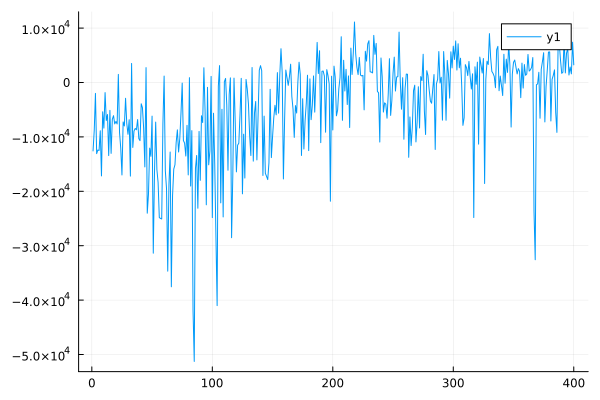

In [25]:
plot(episode_test_reward_hook.rewards)

In [26]:
close_visualization(); # closes the MeshCat visualization